## General Information

This notebook is used to train a simple neural network model to predict the chemistry in the barite benchmark (50x50 grid). The training data is stored in the repository using **git large file storage** and can be downloaded after the installation of git lfs using the `git lfs pull` command.

It is then recommended to create a Python environment using miniconda. The necessary dependencies are contained in `environment.yml` and can be installed using `conda env create -f environment.yml`.

The data set is divided into a design and result part and consists of the iterations of a reference simulation. The design part of the data set contains the chemical concentrations at time $t$ and the result part at time $t+1$, which are to be learned by the model.

## Setup Libraries

In [1]:
import keras
import h5py
import numpy as np
import pandas as pd
import time
import sklearn.model_selection as sk
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import os
from preprocessing import *
from sklearn import set_config
set_config(transform_output = "pandas")

2025-01-23 14:37:53.766781: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-23 14:37:53.786741: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Running Keras in version 3.6.0


## Define parameters

In [40]:
dtype = "float32"
activation = "relu"

lr = 0.001
batch_size = 512
epochs = 50 # default 400 epochs

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps=2000,
    decay_rate=0.9,
    staircase=True
)

optimizer_simple = keras.optimizers.Adam(learning_rate=lr_schedule)
optimizer_large = keras.optimizers.Adam(learning_rate=lr_schedule)

loss = keras.losses.MeanSquaredError()

sample_fraction = 0.8

## Setup the model

In [41]:
# small model
model_simple = keras.Sequential(
    [
        keras.Input(shape = (12,), dtype = "float32"),
        keras.layers.Dense(units = 128, activation = "relu", dtype = "float32"),
        keras.layers.Dense(units = 128, activation = "relu", dtype = "float32"),
        keras.layers.Dense(units = 12, dtype = "float32")
    ]
)

model_simple.compile(optimizer=optimizer_simple, loss = loss)
model_simple.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,724 (77.05 KB)

 Trainable params: 19,724 (77.05 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# large model
model_large =   keras.Sequential(
    [keras.layers.Input(shape=(12,), dtype=dtype),
     keras.layers.Dense(512, activation='relu', dtype=dtype),
     keras.layers.Dense(1024, activation='relu', dtype=dtype),
     keras.layers.Dense(512, activation='relu', dtype=dtype),
     keras.layers.Dense(12, dtype=dtype)
     ])

model_large.compile(optimizer=optimizer_large, loss = loss)
model_large.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,062,924 (4.05 MB)

 Trainable params: 1,062,924 (4.05 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# model from paper

## Define transformer functions

In [6]:
def Safelog(val):
    # get range of vector
    if val > 0:
        return np.log10(val)
    elif val < 0:
        return -np.log10(-val)
    else:
        return 0

def Safeexp(val):
    if val > 0:
        return -10 ** -val
    elif val < 0:
        return 10 ** val
    else:
        return 0

In [7]:
# ? Why does the charge is using another logarithm than the other species

func_dict_in = {
    "H" : np.log1p,
    "O" : np.log1p,
    "Charge" : Safelog,
    "H_0_" : np.log1p,
    "O_0_" : np.log1p,
    "Ba" : np.log1p,
    "Cl" : np.log1p,
    "S_2_" : np.log1p,
    "S_6_" : np.log1p,
    "Sr" : np.log1p,
    "Barite" : np.log1p,
    "Celestite" : np.log1p,
}

func_dict_out = {
    "H" : np.expm1,
    "O" : np.expm1,
    "Charge" : Safeexp,
    "H_0_" : np.expm1,
    "O_0_" : np.expm1,
    "Ba" : np.expm1,
    "Cl" : np.expm1,
    "S_2_" : np.expm1,
    "S_6_" : np.expm1,
    "Sr" : np.expm1,
    "Barite" : np.expm1,
    "Celestite" : np.expm1,
}


## Read data from `.h5` file and convert it to a `pandas.DataFrame`

In [59]:
# os.chdir('/mnt/beegfs/home/signer/projects/model-training')
data_file = h5py.File("Barite_50_Data_training.h5")

design = data_file["design"]
results = data_file["result"]

df_design = pd.DataFrame(np.array(design["data"]).transpose(), columns = design["names"].asstr())
df_results = pd.DataFrame(np.array(results["data"]).transpose(), columns = results["names"].asstr())

data_file.close()

## Preprocess Data

The data are preprocessed in the following way:

1. Label data points in the `design`  dataset with `reactive` and `non-reactive` labels using kmeans clustering
2. Transform `design` and `results` data set into log-scaled data.
3. Split data into training and test sets.
4. Learn scaler on training data for `design` and `results` together (option `global`) or individual (option `individual`).
5. Transform training and test data.
6. Split training data into training and validation dataset.

In [9]:
X_train, X_val, X_test, y_train, y_val, y_test, scaler_X, scaler_y = preprocessing_training(df_design, df_results, func_dict_in, func_dict_out, "over", 'individual', 0.1)

/home/signer/bin/miniconda3/envs/training/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Amount class 0 before: 0.9879169719169719
Amount class 1 before: 0.012083028083028084
Using Oversampling
Amount class 0 after: 0.5
Amount class 1 after: 0.5


## Custom Loss function

In [164]:
def custom_loss_H20(df_design_log, df_result_log, data_min_log, data_max_log, func_dict_out, postprocess):
    df_result = postprocess(df_result_log, func_dict_out, data_min_log, data_max_log)    
    return keras.losses.Huber + np.sum(((df_result['H'] / df_result['O']) - 2)**2)

def loss_wrapper(data_min_log, data_max_log, func_dict_out, postprocess):
    def loss(df_design_log, df_result_log):
        return custom_loss_H20(df_design_log, df_result_log, data_min_log, data_max_log, func_dict_out, postprocess)
    return loss

## Train the model

In [42]:
# measure time
start = time.time()
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model_simple.fit(X_train.iloc[:, X_train.columns != "Class"], 
            y_train.iloc[:, y_train.columns != "Class"], 
            batch_size = batch_size, 
            epochs = 20, 
            validation_data = (X_val.iloc[:, X_val.columns != "Class"], y_val.iloc[:, y_val.columns != "Class"]),
            callbacks = [callback])

end = time.time()

print("Training took {} seconds".format(end - start))

Epoch 1/20
7823/7823 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0018 - val_loss: 3.6601e-05
Epoch 2/20
7823/7823 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 3.6899e-05 - val_loss: 3.6822e-05
Epoch 3/20
7823/7823 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 3.5005e-05 - val_loss: 3.5655e-05
Epoch 4/20
7823/7823 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 3.4032e-05 - val_loss: 3.3455e-05
Epoch 5/20
7823/7823 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 3.3279e-05 - val_loss: 3.3064e-05
Epoch 6/20
7823/7823 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 3.3023e-05 - val_loss: 3.3338e-05
Epoch 7/20
7823/7823 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 3.2532e-05 - val_loss: 3.2765e-05
Epoch 8/20
7823/7823 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 3.2749e-05 - val_loss: 3.2730e-05
Epoch 9/20
7823/7823 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 3.2961e-05 - val_loss: 3.2593e-05
Epoch 10/20
7823/7823 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 3.2573e-05 - val_loss: 3.2576e-05
Epoch 11/20
7823/7823 ━━━━━━━━━━━

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


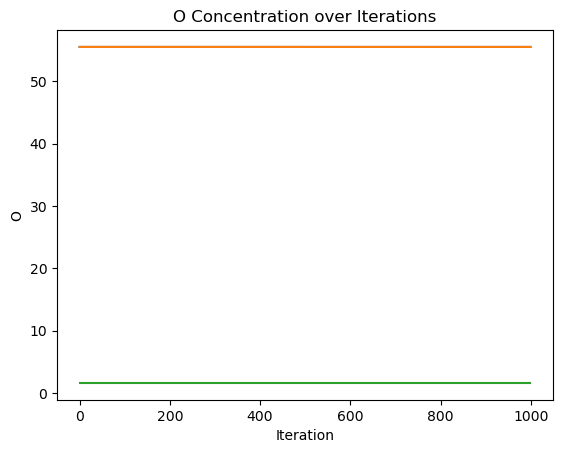

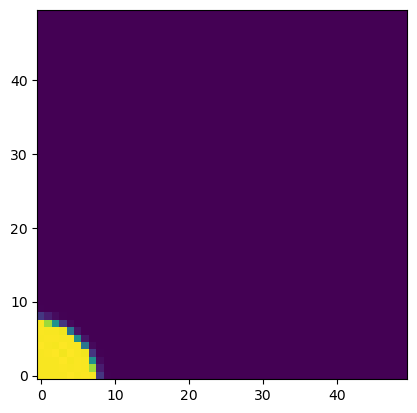

In [69]:

import matplotlib.pyplot as plt

species = "O"
iterations = 1000
cell_offset = 60
y_design = []
y_results = []
for i in range(0,iterations):
    idx = i*50*50 + cell_offset -1
    y_design.append(df_design.iloc[idx, :])
    y_results.append(df_results.iloc[idx,:])
    
y_design = pd.DataFrame(y_design)
y_results = pd.DataFrame(y_results)
plt.plot(np.arange(0,iterations), y_design[species], label = "Design")
plt.plot(np.arange(0,iterations), y_results[species], label = "Results")

y = FuncTransform(func_dict_in, func_dict_out).fit_transform(y_design)
y = scaler_X.transform(y)
prediction = model_large.predict(y.iloc[:, y.columns != "Class"])
prediction = pd.DataFrame(prediction, columns = y.columns[y.columns != "Class"])
prediction_back = pd.DataFrame(scaler_X.inverse_transform(prediction), columns=prediction.columns)
prediction_back = FuncTransform(func_dict_out, func_dict_in).inverse_transform(prediction_back.iloc[:, prediction_back.columns != "Class"])

plt.plot(np.arange(0,iterations), prediction_back[species], label = "Prediction")
plt.xlabel('Iteration')
plt.ylabel(species)
plt.title(species+' Concentration over Iterations')
plt.show()

timestep = 1000
plt.imshow(np.array(df_results["Barite"][(timestep*2500):(timestep*2500+2500)]).reshape(50,50), origin='lower')

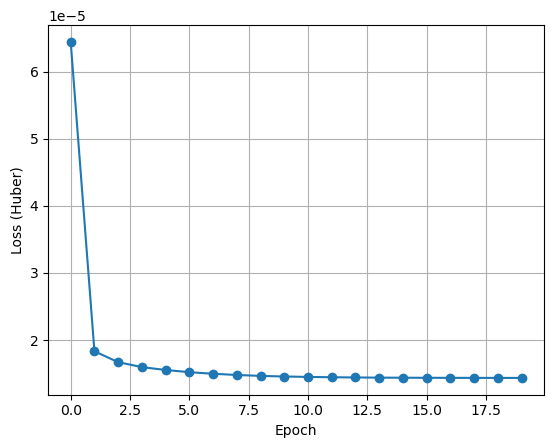

In [13]:
plt.plot(history.history["loss"], "o-", label = "Training Loss")
plt.xlabel("Epoch")
# plt.yscale('log')
plt.ylabel("Loss (Huber)")
plt.grid('on')

plt.savefig("loss_all.png", dpi=300)


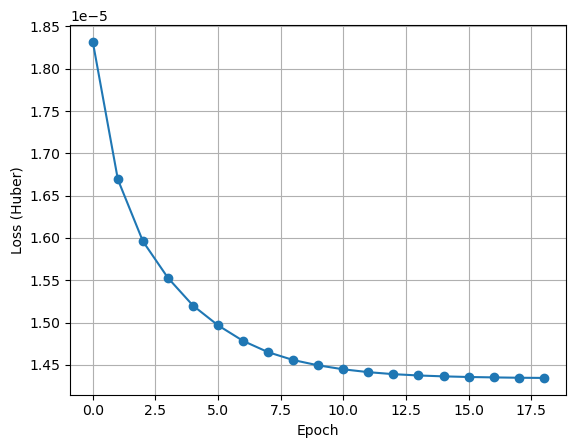

In [14]:
plt.plot(history.history["loss"][1:], "o-", label = "Training Loss")
plt.xlabel("Epoch")
# plt.yscale('log')
plt.ylabel("Loss (Huber)")
plt.grid('on')
plt.savefig("loss_1_to_end.png", dpi=300)


## Test the model

In [15]:
# test on all test data
model_large.evaluate(X_test.iloc[:,X_test.columns != "Class"], y_test.iloc[:, y_test.columns != "Class"])

  20/7821 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - loss: 5.1914e-06

7821/7821 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 1.0395e-06


9.875676596493577e-07

In [16]:
# test on non-reactive data
model_large.evaluate(X_test[X_test['Class'] == 0].iloc[:,:-1], y_test[X_test['Class'] == 0].iloc[:,:-1])

7727/7727 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 5.4493e-07


5.075861508885282e-07

In [17]:
# test on reactive data
model_large.evaluate(X_test[X_test['Class'] == 1].iloc[:,:-1], y_test[X_test['Class'] == 1].iloc[:, :-1])

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0710e-05


4.047931361128576e-05

## Save the model

In [53]:
# Save the model
model.save("Barite_50_Model_additional_species.keras")

## Legacy Code

def log_scale(df_design, df_result, func_dict):
    
    df_design = df_design.copy()
    df_result = df_result.copy()
    
    for key in df_design.keys():
        if key != "Class":
            df_design[key] = np.vectorize(func_dict[key])(df_design[key])
            df_result[key] = np.vectorize(func_dict[key])(df_result[key])
        
    return df_design, df_result

# Get minimum and maximum values for each column
def get_min_max(df_design, df_result):
    
    min_vals_des = df_design.min()
    max_vals_des = df_design.max()
    
    min_vals_res = df_result.min()
    max_vals_res = df_result.max()

    # minimum of input and output data to get global minimum/maximum
    data_min = np.minimum(min_vals_des, min_vals_res).to_dict()
    data_max = np.maximum(max_vals_des, max_vals_res).to_dict()

    return data_min, data_max

df_design_log, df_results_log = log_scale(df_design, df_results, func_dict_in)
data_min_log, data_max_log = get_min_max(df_design_log, df_design_log)

train_min_log, train_max_log = get_min_max(X_train_log, y_train_log)
test_min_log, test_max_log = get_min_max(X_test_log, y_test_log)

X_train_preprocess = preprocess(X_train_log, func_dict_in, train_min_log, train_max_log)
y_train_preprocess = preprocess(y_train_log, func_dict_in, train_min_log, train_max_log)

X_test_preprocess = preprocess(X_test_log, func_dict_in, test_min_log, test_max_log)
y_test_preprocess = preprocess(y_test_log, func_dict_in, test_min_log, test_max_log)

X_train_log, y_train_log = log_scale(X_train, y_train, func_dict_in)
X_test_log, y_test_log = log_scale(X_test, y_test, func_dict_in)


def preprocess(data, func_dict, data_min, data_max):
    data = data.copy()
    for key in data.keys():
        if key != "Class":
            data[key] = (data[key] - data_min[key]) / (data_max[key] - data_min[key])

    return data

def postprocess(data, func_dict, data_min, data_max):
    data = data.copy()
    for key in data.keys():
        if key != "Class":
            data[key] = data[key] * (data_max[key] - data_min[key]) + data_min[key]
            data[key] = np.vectorize(func_dict[key])(data[key])
    return data

X_train, X_val, y_train, y_val = sk.train_test_split(X_train_preprocess, y_train_preprocess, test_size = 0.1)

pp_design = preprocess(df_design_log, func_dict_in, data_min_log, data_max_log)
pp_results = preprocess(df_results_log, func_dict_in, data_min_log, data_max_log)